In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


## A

Due to space issues on my computer, I directly worked on kaggle, thus the path to retrieve the dataset.

In [6]:
data_df = pd.read_csv("/kaggle/input/santander-customer-transaction-prediction/train.csv")
X_df = data_df.iloc[:,2:].copy()
y_df =  data_df.iloc[:,1].copy()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_df, y_test_df = train_test_split(
    X_df, y_df, random_state=1, test_size=0.5)

## B

In [8]:
label_1 = y_df.sum()
ratio = label_1/len(y_df)
print('Ratio of label 1 : {}'.format(ratio))

Ratio of label 1 : 0.10049


Only 10% of the dataset is composed of the label 1 --> The dataset is not equilibrated. Therefore a good model should provide an accuracy above 90% as a predicting that all outputs are 0 would ensure such an accuracy.

In [9]:
X_df.head(2)


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


The input is composed in total of 200 000 single inputs (therefore the training and testing datasets each contain 100 000 inputs). Each input has 200 features. This high number of features justifies the use of a Bayesian approach compared to other machine learning meathods. As a matter of fact, due to the class independence assumption, the model doesn't have to take into account any possible correlation between the different features and therefore needs less input data to train.

# 1. Bayesian Linear Regression

## 1A

In [10]:
def compute_posterior(X, y, sigma2priorweights, sigma2noise):
    Sigma_inverse =    1/sigma2noise*X.T@X + np.diag([sigma2priorweights]*len(X[0]))
    posterior_mu = np.linalg.solve(Sigma_inverse, X.T@y)/sigma2noise
    posterior_Sigma =  np.linalg.solve(Sigma_inverse, np.identity(len(Sigma_inverse)))
    return posterior_mu, posterior_Sigma

In [11]:
def compute_predictive(Xnew, w_posterior_mu, w_posterior_Sigma, sigma2noise):
    y_posterior_mu = Xnew@w_posterior_mu
    #y_posterior_Sigma = sigma2noise + Xnew@w_posterior_Sigma@Xnew.T
    return y_posterior_mu #,y_posterior_Sigma

## 1B

We first need to transform the dataframes into numpy arrays in order to be able to compute the posterior.
The input will then be in the right format to apply linear regression as for each input point (represented on a row of the array), the features are in different columns.

In [12]:
X_train = X_train.to_numpy()
y_train = y_train_df.to_numpy()

# 1C

In [13]:
sigma2noise = 1
sigma2priorweights = 1
w_posterior_mu, w_posterior_Sigma = compute_posterior(X_train, y_train, sigma2priorweights, sigma2noise)


In [14]:
print(w_posterior_Sigma)

[[ 1.08168387e-06  2.04199094e-09 -7.83109906e-09 ... -1.13698658e-08
   7.13138344e-09 -2.58127466e-09]
 [ 2.04199094e-09  6.13091896e-07 -1.97418983e-09 ...  1.93513182e-08
   3.72479156e-09 -3.22587927e-10]
 [-7.83109906e-09 -1.97418983e-09  1.43915291e-06 ...  1.77215026e-08
   2.96181137e-09 -2.37691051e-09]
 ...
 [-1.13698658e-08  1.93513182e-08  1.77215026e-08 ...  1.17772909e-05
  -8.19464307e-09 -6.46639263e-10]
 [ 7.13138344e-09  3.72479156e-09  2.96181137e-09 ... -8.19464307e-09
   1.10035885e-06  1.58767682e-09]
 [-2.58127466e-09 -3.22587927e-10 -2.37691051e-09 ... -6.46639263e-10
   1.58767682e-09  9.15870342e-08]]


The variance of the posterior characterizes the dispersion of the parameter. The low values show that the uncertainty on the model parameter is small. The larger values on the diagonal compared to the values in the rest of the covariance matrix strenghtens the previous assumption of uncorrelated features.

# 1D

The predicted outputs are floats between 0 and 1. Therefore, in order to classify the predictions into two different classes, one has to find the threshold dividing the predictions. If the threshold value is 0.5, the predictions are therefore classified accordingly to their distance to the labels. Therefore a prediction of 0.3 is closer to 0 and will be classified as such.

In [15]:
threshold = 0.5
y_posterior_mu = compute_predictive(X_test, w_posterior_mu, w_posterior_Sigma, sigma2noise) 
y_pred = np.array(y_posterior_mu > threshold).astype(int)

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_test = y_test_df.to_numpy()
cm_linear_regression = confusion_matrix(y_test, y_pred)
print(cm_linear_regression)

[[90003    26]
 [ 9710   261]]


--> From the confusion matrix, we can see that the majority of the errors come from data labelled as 1 but classified as 0. (threshold = 0.5)

In [17]:
accuracy_linear_regression = accuracy_score(y_test, y_pred)
print('Accuracy of linear regression : {}'.format(accuracy_linear_regression))
error_rate_linear_regression = 1 - accuracy_linear_regression

Accuracy of linear regression : 0.90264


--> We obtain a 90% accuracy (which is the same accuracy than if all the data was predicted as 0). This accuracy remains around 90% with a threshold from 0.3 to 1 (at 1 all the labels are classified as 0 thus the 90% accuracy).

# Logistic Regression

## 2A : Markov Chain Monte Carlo

In [18]:
import torch
def set_seed(seed: int=0):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [19]:
def logistic(z):
    return 1/(1+np.exp(-z))

In [20]:
class BernoulliLikelihood():
    def logdensity(self, y, p):
        return y*np.log(p) + (1-y)*np.log(1-p)

class NormalPrior():
    def __init__(self, sigma2x):
        self.sigma2x = sigma2x
        
    def logdensity(self, x):
        return -1/(2*self.sigma2x)*x.T@x

In [21]:
class MHSampler():
    @property
    def samples(self):
        return self._samples
    @samples.getter    
    def samples(self):
        return np.asarray(self._samples)
    
    def __init__(self, initial_sample, likelihood, prior):
        self.likelihood = likelihood
        self.prior = prior
        self._samples = [initial_sample]
        self.acceptance_rate = 0
        
        
    def unnormalized_logposterior(self, w, X, y):
        log_likelihood = self.likelihood.logdensity(y, logistic((w.T@X)))
        log_prior = self.prior.logdensity(w)
        return (log_likelihood + log_prior)[0][0]

    def step(self, X, y, step_proposal):
        w_prev = self._samples[-1]
        w_proposal = np.random.randn(200, 1)*step_proposal + w_prev 
        
        log_gw_prev = self.unnormalized_logposterior(w_prev, X, y)
        log_gw_proposal = self.unnormalized_logposterior(w_proposal, X, y)
        acceptance_ratio = np.exp(log_gw_proposal - log_gw_prev) ###TO COMPLETE
        
        if acceptance_ratio >=1:
            self._samples.append(w_proposal)
        else:
            u = np.random.uniform(0,1)
            if u<=acceptance_ratio:
                self._samples.append(w_proposal)
                self.acceptance_rate += 1
            else:
                self._samples.append(w_prev)
        return min(acceptance_ratio, 1)

In [22]:
set_seed()

number_steps = 1000
step_size = 10**(-1)
likelihood = BernoulliLikelihood()
prior = NormalPrior(1)

starting_point = np.random.randn(200, 1)
sampler = MHSampler(starting_point, likelihood, prior)
for _ in range(number_steps):
        sampler.step(X_train.T, y_train, step_size)
samples_MCMC = sampler.samples

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


## 2B : Variational Inference

To use the variational inference algorithm we need to normalize the features of the inputs. As a matter of fact, if the features aren't noramlized, the gradients can either vanish or explode over cascaded layers of a neural network.

In [23]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_scaler.fit(X_df)
X = X_scaler.transform(X_df)

from sklearn.model_selection import train_test_split
X_train_norm, X_test_norm, y_train_df_norm, y_test_df_norm = train_test_split(
    X, y_df, random_state=1, test_size=0.5)
y_train_norm = y_train_df_norm.to_numpy()

In [24]:
import numpy as np
import scipy as scipy
import scipy.spatial
import time 

import matplotlib 
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import pandas as pd
import torch
import torch.nn as nn

warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def args_as_tensors(*index):
    """A simple decorator to convert numpy arrays to torch tensors"""
    def decorator(method):
        def wrapper(*args, **kwargs):
            converted_args = [torch.tensor(a).float() 
                              if i in index and type(a) is np.ndarray else a 
                              for i, a in enumerate(args)]
            return method(*converted_args, **kwargs)
        return wrapper  
    return decorator

In [25]:
jitter = 1e-10

class Distribution(nn.Module):  
    pass

class Bernoulli(Distribution):
    @args_as_tensors(1, 2)
    def logdensity(self, y, p):
        return y*torch.log(p+jitter) + (1-y)*torch.log(1-p+jitter)

In [26]:
class NormalDiagonal(Distribution):
    @property
    def var(self):
        return self.logvar.exp()
    
    def extra_repr(self):
        return 'train=%s' % self.train
    
    def __init__(self, d, train=True):
        super(NormalDiagonal, self).__init__()
        self.train = train
        self.d = d
        self.mean = nn.Parameter(torch.zeros(d), requires_grad=train)
        self.logvar = nn.Parameter(torch.zeros(d), requires_grad=train)
    
    def sample(self, n=1):
        eps = torch.randn(n,self.d,requires_grad=self.train) 
        samples = self.mean + eps*(torch.sqrt((self.var)))
        return samples

In [27]:
from functools import total_ordering

_KL_REGISTRY = {}  # Source of truth mapping a few general (type, type) pairs to functions.
_KL_MEMOIZE = {}  # Memoized version mapping many specific (type, type) pairs to functions.

@total_ordering
class _Match(object):
    __slots__ = ['types']

    def __init__(self, *types):
        self.types = types

    def __eq__(self, other):
        return self.types == other.types

    def __le__(self, other):
        for x, y in zip(self.types, other.types):
            if not issubclass(x, y):
                return False
            if x is not y:
                break
        return True

def _dispatch_kl(type_q, type_p):
    matches = [(super_q, super_p) for super_q, super_p in _KL_REGISTRY
               if issubclass(type_q, super_q) and issubclass(type_p, super_p)]
    if not matches:
        return NotImplemented
    left_q, left_p = min(_Match(*m) for m in matches).types
    right_p, right_q = min(_Match(*reversed(m)) for m in matches).types
    left_fun = _KL_REGISTRY[left_q, left_p]
    right_fun = _KL_REGISTRY[right_q, right_p]
    if left_fun is not right_fun:
        logger.warning('Ambiguous kl_divergence({}, {}). Please register_kl({}, {})'.format(
            type_q.__name__, type_p.__name__, left_q.__name__, right_p.__name__))
    return left_fun


def register_kl(type_q, type_p):
    """
    Decorator to register a pairwise function with kl_divergence.
    Usage:

        @register_kl(Normal, Normal)
        def kl_normal_normal(q, p):
            # insert implementation here
    """
    if not isinstance(type_q, type) and issubclass(type_q, BaseDistribution):
        raise TypeError('Expected type_q to be a Distribution subclass but got {}'.format(type_q))
    if not isinstance(type_p, type) and issubclass(type_p, BaseDistribution):
        raise TypeError('Expected type_p to be a Distribution subclass but got {}'.format(type_p))
    
    def decorator(fun):
        _KL_REGISTRY[type_q, type_p] = fun
        _KL_MEMOIZE.clear()  # reset since lookup order may have changed
        print('KL divergence between \'%s\' and \'%s\' registered.' % (type_q.__name__, type_p.__name__))
        return fun
    return decorator


def kl_divergence(q, p):
    r"""Compute Kullback-Leibler divergence KL(p|q) between two distributions."""
    try:
        fun = _KL_MEMOIZE[type(q), type(p)]
    except KeyError:
        fun = _dispatch_kl(type(q), type(p))
        _KL_MEMOIZE[type(q), type(p)] = fun
    if fun is NotImplemented:
        raise NotImplementedError('KL divergence for pair %s - %s not registered' % (type(q).__name__,
                                                                                     type(p).__name__))
    return fun(q, p)

In [28]:
@register_kl(NormalDiagonal, NormalDiagonal)
def _normaldiagonal_normaldiagonal(q, p):
    kl = (1/2) * torch.sum(p.logvar - q.logvar + (q.var + (q.mean - p.mean)**2)/p.var - 1)
    return kl

KL divergence between 'NormalDiagonal' and 'NormalDiagonal' registered.


In [29]:
def logistic_tensor(z):
    return 1/(1 + torch.exp(-z))


class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        
        self.prior_w = NormalDiagonal(input_dim)## *** TO COMPLETE *** ##
        self.posterior_w = NormalDiagonal(input_dim) ## *** TO COMPLETE *** ##
        
    @args_as_tensors(1)
    def predict_y(self, X, mc_samples=1):
        w_samples = self.posterior_w.sample(mc_samples)
        w_samples=torch.unsqueeze(w_samples, dim=2)
        y_samples = logistic_tensor(X @ w_samples)
        
        return y_samples

In [30]:
class VariationalObjective(nn.Module):    
    def __init__(self, model, likelihood, N, mc_samples):
        super(VariationalObjective, self).__init__()
        self.N = N
        self.model = model
        self.likelihood = likelihood
        self.mc_samples = mc_samples
        
    def expected_loglikelihood(self, Xbatch, ybatch):
        ypred = model.predict_y(Xbatch, self.mc_samples)
        logliks = self.likelihood.logdensity(ybatch, ypred)
        return - (self.N/(self.mc_samples*Xbatch.shape[0]))*torch.sum(logliks)

    
    def kl(self):
        return kl_divergence(self.model.posterior_w, self.model.prior_w) 
    
    def compute_objective(self, Xbatch, ybatch):
        return self.expected_loglikelihood(Xbatch, ybatch) + self.kl() 

In [31]:
class Dataset():
    def __init__(self, X, y, minibatch_size):
        self.X = X
        self.y = y 
        self.minibatch_size = min(minibatch_size, len(self.X))
        self._i = 0  
    def next_batch(self):  
        if len(self.X) <= self._i + self.minibatch_size:
            shuffle = np.random.permutation(len(self.X))
            self.X = self.X[shuffle]
            self.y = self.y[shuffle]
            Xbatch = self.X[self._i:]
            ybatch = self.y[self._i:]
            self._i = 0
            return Xbatch, ybatch

        Xbatch = self.X[self._i:self._i + self.minibatch_size]
        ybatch = self.y[self._i:self._i + self.minibatch_size]
        self._i += self.minibatch_size
        return Xbatch, ybatch

In [32]:
class Summary:
    @property
    def data(self):
        data = pd.DataFrame(self._data, columns=['step', self.name, 'time'])
        data.time = data.time - data.time.iloc[0]
        return data
    
    def __init__(self, name):
        """A simple class to store some values during optimization"""
        self.name = str(name)
        self._data = []
    
    def append(self, step, value):
        self._data.append([step, float(value.detach().numpy()), time.time()])

In [33]:
set_seed()
lr = 10**(-5)
batch_size = 100

dataset = Dataset(X_train_norm, y_train_norm, minibatch_size = batch_size)
likelihood = Bernoulli()
model = LogisticRegression(len(X_train_norm[0]))

nelbo = VariationalObjective(model, likelihood, len(X_train_norm[0]), mc_samples = 1000)
nelbo_summary = Summary('nelbo')
nll_summary = Summary('expected_loglik')
kl_summary = Summary('kl')
from IPython.display import clear_output
optim = torch.optim.SGD(filter(lambda p: p.requires_grad,model.parameters()), lr = lr) #SGD
num_iterations = 1000

for step in range(num_iterations):
    optim.zero_grad()
    Xbatch, ybatch = dataset.next_batch()
    loss = nelbo.compute_objective(Xbatch, ybatch)

    nelbo_summary.append(step, loss)
    nll_summary.append(step, loss - nelbo.kl())
    kl_summary.append(step, nelbo.kl())

    loss.backward()
    optim.step()
    clear_output()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(step, num_iterations, loss.item()))


Epoch [999/1000], Loss: 31790.1445


## 2C : Predictive distribution

#### Prediction for MCMC

In [34]:
def predict(x_new, w_samples):
    p = 0
    for w in w_samples:
        p += logistic(w.T @ x_new)
    return p / len(w_samples)

In [35]:
predictions_mcmc = np.array(predict(X_test.T, samples_MCMC))

In [36]:
log_likelihood_mcmc = BernoulliLikelihood().logdensity(y_test, predictions_mcmc[0])
log_likelihood_mcmc_no_nan = [x for x in log_likelihood_mcmc if (~np.isnan(x) and ~np.isinf(x))]
mean_log_likelihood_mcmc = np.mean(log_likelihood_mcmc_no_nan)
print('Mean loglikelihood for MCMC : {}'.format(mean_log_likelihood_mcmc))

y_pred_mcmc = np.array(predictions_mcmc > 0.5).astype(int)
acc_mcmc = accuracy_score(y_test, y_pred_mcmc[0])
error_rate_mcmc = 1 - acc_mcmc
print('Error rate for MCMC : {}'.format(error_rate_mcmc))

cm_mcmc = confusion_matrix(y_test, y_pred_mcmc[0])
print(cm_mcmc)

Mean loglikelihood for MCMC : -0.6189762133470926
Error rate for MCMC : 0.30042
[[66838 23191]
 [ 6851  3120]]


#### Predictions for variational inference

In [37]:
predictions_vi = model.predict_y(X_test_norm).detach().numpy()

In [38]:
log_likelihood_vi = Bernoulli().logdensity(y_test, predictions_vi[0].T[0]).detach().numpy()
log_likelihood_vi_no_nan = [x for x in log_likelihood_vi if (~np.isnan(x) and ~np.isinf(x))]
mean_log_likelihood_vi = np.mean(log_likelihood_vi_no_nan)
print('Mean loglikelihood for VI : {}'.format(mean_log_likelihood_vi))

y_pred_vi = np.array(predictions_vi > 0.5).astype(int)
acc_vi = accuracy_score(y_test, y_pred_vi[0])
error_rate_vi = 1 - acc_vi
print('Error rate for VI : {}'.format(error_rate_vi))

cm_vi = confusion_matrix(y_test, y_pred_vi[0])
print(cm_vi)

Mean loglikelihood for VI : -1.5140644311904907
Error rate for VI : 0.49349
[[45387 44642]
 [ 4707  5264]]


## 2D : Tuning of Metropolis Hastings

In [39]:
set_seed()

number_steps = 1000
step_size = [10**(-i) for i in range(1,3)]
accuracy = []
acceptance_rate = []

for s in step_size:
    likelihood = BernoulliLikelihood()
    prior = NormalPrior(1)

    starting_point = np.random.randn(200, 1)
    sampler = MHSampler(starting_point, likelihood, prior)
    
    for _ in range(number_steps):
        sampler.step(X_train.T, y_train, s)
    ps = predict(X_test.T, sampler.samples[round(0.1 * number_steps):]) #burn-in of 10% of the samples
    y_pred = np.array(ps > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred[0])
    accuracy.append(acc)
    acceptance_rate.append(sampler.acceptance_rate/number_steps)
    print(s)
    print(acc)
    print(sampler.acceptance_rate/number_steps)

0.1
0.70931
0.199
0.01
0.52143
0.0


For 1000 samples

<table>
<tr>
<th>Step size</th>
<th>Accuracy</th>
<th>Acceptance rate</th>
</tr>
    
<tr>
<td>0.0001</td>
<td>0.88</td>
<td>0.50</td>
</tr>
    
<tr>
<td>0.001</td>
<td>0.88</td>
<td>0.47</td>
</tr>

<tr>
<td>0.01</td>
<td>0.52</td>
<td>0</td>
</tr>

<tr>
<td>0.1</td>
<td>0.70</td>
<td>0.199</td>
</tr>

<tr>
<td>0.2</td>
<td>0.51</td>
<td>0.167</td>
</tr>
    
<tr>
<td>0.3</td>
<td>0.20</td>
<td>0.092</td>
</tr>
    
<tr>
<td>0.4</td>
<td>0.12</td>
<td>0.001</td>
</tr>
</table>

The step proposal determines the variance:
- a low variance (small step size) will lead to highly correlated samples
- a high variance (larger step size) will lead to a lower acceptance rate as many samples will be rejected as they don't belong to the aread of high density in the posterior space. As shown in the results, the acceptance rate decreases with the augmentation of the step size.

The optimal acceptance rate for multi dimension distributions is believed to be equal to 0.234, which is coherent with the results obtained : the higher accuracy is achieved when the acceptance rate is close to this value.

In order to ensure that samples are representative of samples of the posterior over model
parameters, one can use the burn-in method. For a step size of 0.1 and 1000 samples, the accuracy is now 71% (instead of 70%). This small difference is due to the fact that if there are enough samples, the first samples coming from a random point will not matter.

## 2E : Tuning of Variational Inference

--> In order to tune the variational inference algorithm, a grid search was implemented on the learning rate and the minibatch size in order to find the optimal values.

In [40]:
set_seed()
lr = [10**(-i) for i in range(5,8)]
minibatch_size = [10**i for i in range(3)]
accuracy = np.zeros((len(lr), len(minibatch_size)))

for l in range(len(lr)):
    for s in range(len(minibatch_size)):
        
        dataset = Dataset(X_train_norm, y_train, minibatch_size = minibatch_size[s])

        likelihood = Bernoulli()
        model = LogisticRegression(len(X_train[0]))

        nelbo = VariationalObjective(model, likelihood, len(X_train_norm[0]), mc_samples = 1000)
        nelbo_summary = Summary('nelbo')
        nll_summary = Summary('expected_loglik')
        kl_summary = Summary('kl')
        from IPython.display import clear_output
        #optim = torch.optim.SGD(filter(lambda p: p.requires_grad,model.parameters()), lr = lr[l])
        #optim = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr = lr[l])
        optim = torch.optim.Adagrad(filter(lambda p: p.requires_grad,model.parameters()), lr = lr[l])
        num_iterations = 1000

        for step in range(num_iterations):
            optim.zero_grad()
            Xbatch, ybatch = dataset.next_batch()
            loss = nelbo.compute_objective(Xbatch, ybatch)

            nelbo_summary.append(step, loss)
            nll_summary.append(step, loss - nelbo.kl())
            kl_summary.append(step, nelbo.kl())

            loss.backward()
            optim.step()
            clear_output()
            print('Lr: {}, Batch: {}, Epoch [{}/{}], Loss: {:.4f}'.format(lr[l], minibatch_size[s], step, num_iterations, loss.item()))
            
        ypred = model.predict_y(X_test_norm).detach().numpy()[0].T[0]
        y_pred = np.array(ypred > 0.5).astype(int)

        accuracy[l][s] = accuracy_score(y_test, y_pred)


Lr: 1e-07, Batch: 100, Epoch [999/1000], Loss: 111826.9844


In [43]:
(l, s) = np.unravel_index(accuracy.argmax(), accuracy.shape)
print('Optimal learning rate : {}, mini-batch size : {}'.format(lr[l], minibatch_size[s]))

Optimal learning rate : 1e-05, mini-batch size : 1


###### Choice of the optimizer

For lr = 10**(-5), minibatch_size = 100, 1000 steps
<table>
<tr>
<th>Optimizer</th>
<th>Accuracy</th>
<th>Loss at Epoch 1000</th>
</tr>
    
<tr>
<td>SGD</td>
<td>50.7 %</td>
<td>531 790</td>
</tr>

<tr>
<td>Adam</td>
<td>50.8%</td>
<td>111 228</td>
</tr>

<tr>
<td>Adagrad</td>
<td>50.8%</td>
<td>116 634</td>
</tr>

</table>

The choice of the optimizer doesn't in fact have much effect on the quality of the prediction. However the Stochastic Gradient Descent (SGD) allows us to reach a lower loss.


## 2F

In [42]:
print('Error rate for Linear Regression : {}'.format(error_rate_linear_regression))
print('Error rate for MCMC : {}'.format(error_rate_mcmc))
print('Error rate for Variational Inference: {}'.format(error_rate_vi))

Error rate for Linear Regression : 0.09736
Error rate for MCMC : 0.30042
Error rate for Variational Inference: 0.49349


In [46]:
print('Confusion Matrix for Linear Regression : \n {}'.format(cm_linear_regression))
print('Confusion Matrix for MCMC : \n {}'.format(cm_mcmc))
print('Confusion Matrix for Variational Inference : \n {}'.format(cm_vi))

Confusion Matrix for Linear Regression : 
 [[90003    26]
 [ 9710   261]]
Confusion Matrix for MCMC : 
 [[66838 23191]
 [ 6851  3120]]
Confusion Matrix for Variational Inference : 
 [[45387 44642]
 [ 4707  5264]]


Despite a lower error rate for linear regression, we can see that this performance is mainly due to the fact that most of the predictions are classified as '1'. The number of false positives is the highest (9710 for Linear Regression, 6851 for MCMC and 4707 for Variational Inference). Therefore as suggested in question B, the imbalanced dataset and the number of features (especially if considered uncorrelated) has an impact when evaluating the model. The "bias" towards the negative class in an imbalanced set originates from the-best-guess-is-majority-class-if-everything-else-is-equal, something which Naive Bayes is sensitive to (especially when a lot of features are involved), thus the high number of false positives for Linear Regression. 

## 2G

In [47]:
print('Mean loglikelihood for MCMC : {}'.format(mean_log_likelihood_mcmc))
print('Mean loglikelihood for VI : {}'.format(mean_log_likelihood_vi))

Mean loglikelihood for MCMC : -0.6189762133470926
Mean loglikelihood for VI : -1.5140644311904907


As we can see, the mean loglikelihood is closer to zero than the mean loglikelihood for Variational Inference meaning that the first has a likelihood closer to 1 than the other. As the likelihood function measures the goodness of fit of a statistical model to a sample of data for given values of the unknown parameters, the results are coherent. As a matter of fact, in Variationanal Inference a bias is introduced as we choose from a family of distributions instead of constructing an approximate distribution directly from the samples.

[]

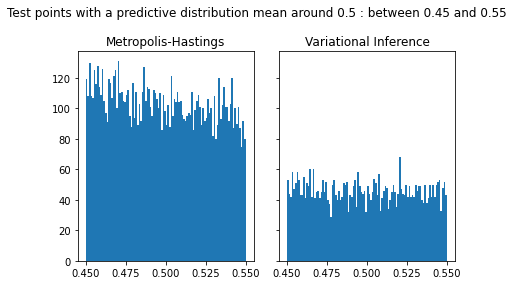

In [62]:
predictions_mcmc_0_5 = [x for x in predictions_mcmc[0] if 0.45 < x < 0.55]
predictions_vi_0_5 = [x for x in predictions_vi[0].T[0] if 0.45 < x < 0.55]

n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('Test points with a predictive distribution mean around 0.5 : between 0.45 and 0.55')
axs[0].hist(predictions_mcmc_0_5, bins=n_bins)
axs[0].title.set_text('Metropolis-Hastings')
axs[1].hist(predictions_vi_0_5, bins=n_bins)
axs[1].title.set_text('Variational Inference')
plt.plot()

[]

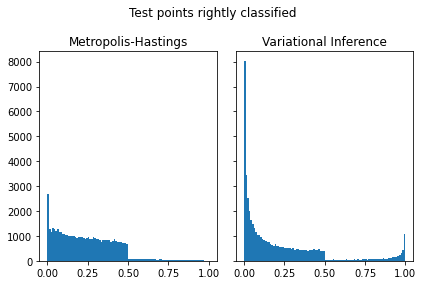

In [59]:
predictions_mcmc_right = [predictions_mcmc[0][i] for i in range (len(predictions_mcmc[0])) if ((predictions_mcmc[0][i]>0.5).astype(int) == y_test[i])]
predictions_vi_right = [predictions_vi[0].T[0][i] for i in range (len(predictions_vi[0])) if ((predictions_vi[0].T[0][i]>0.5).astype(int) == y_test[i])]
predictions_mcmc_right = predictions_mcmc_right[:len(predictions_vi_right)]

n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('Test points rightly classified')
axs[0].title.set_text('Metropolis-Hastings')
axs[0].hist(predictions_mcmc_right, bins=n_bins)
axs[1].title.set_text('Variational Inference')
axs[1].hist(predictions_vi_right, bins=n_bins)
plt.plot()

[]

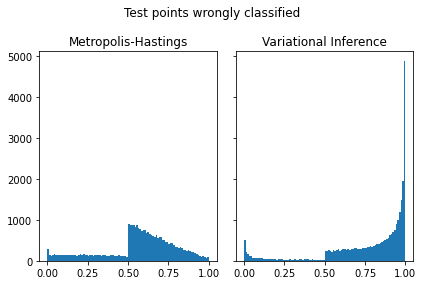

In [61]:
predictions_mcmc_wrong = [predictions_mcmc[0][i] for i in range (len(predictions_mcmc[0])) if ((predictions_mcmc[0][i]>0.5).astype(int) != y_test[i])]
predictions_vi_wrong = [predictions_vi[0].T[0][i] for i in range (len(predictions_vi[0])) if ((predictions_vi[0].T[0][i]>0.5).astype(int) != y_test[i])]
predictions_vi_wrong = predictions_vi_wrong[:len(predictions_mcmc_wrong)]

n_bins = 100
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('Test points wrongly classified')
axs[0].title.set_text('Metropolis-Hastings')
axs[0].hist(predictions_mcmc_wrong, bins=n_bins)
axs[1].title.set_text('Variational Inference')
axs[1].hist(predictions_vi_wrong, bins=n_bins)
plt.plot()

From the graphs we can see that most of the righly classified points are labelled as '0' while the wrongly classified are mainly samples labelled as '0' but classified as '1'.
The main difference between Metropolis-Hastings and Variational Inference is the predictive distribution. As a matter of fact, the Variational Inference one have fewer points towards 0.5 as shown in the first graph and tens to have a higher number of samples with a mean either closer to 0 or 1. The uncertainty on the predictions are therefore lower for the Variational Inference model than for the Metropolis Hastings algorithm.

# Bonus question : Laplace

There seems to be an issue when trying to evaluate the second derivative of log_g in w_hat. I also trie coding my own second derivative using Taylor approximation but the multivariate case was complicated to handle. Due to a lack of time, I wasn't able to fix the issue.

In [ ]:
from jax import hessian
import scipy

class Laplace():
    @property
    def samples(self):
        return self._samples
    @samples.getter    
    def samples(self):
        return np.asarray(self._samples)
    
    def __init__(self, number_samples, likelihood, prior):
        self.likelihood = likelihood
        self.prior = prior
        self.mean = []
        self.n_samples = number_samples
        self._samples = []
    
    def log_g(self, w, X, y):
        w = w.reshape(200,1)
        log_likelihood = self.likelihood.logdensity(y, logistic((w.T@X)))
        log_prior = self.prior.logdensity(w)
        return (log_likelihood + log_prior)[0][0]

    def w_hat(self, X, y):
        max_w = scipy.optimize.fmin(lambda w: -self.log_g(w, X, y), np.random.randn(200, 1))
        return max_w
    
    def inv_sigma(self, X, y):
        return - hessian(lambda w: self.log_g(w, X, y))(self.mean)
    
    def approx(self, X, y):
        self.mean = self.w_hat(X,y).reshape(200,1)
        print('mean ok')
        sigma_inv = self.inv_sigma(X, y)
        print('inv ok')
        sigma = np.linalg.solve(sigma_inv, np.identity(len(sigma_inv)))
        print('sigma ok')
        self._samples = np.random.multivariate_normal(self.mean, sigma, self.n_samples)
        return self._samples

In [ ]:
set_seed()

likelihood = BernoulliLikelihood()
prior = NormalPrior(1)
n_samples = 100
sampler = Laplace(n_samples, likelihood, prior)
sampler.approx(X_train.T, y_train)
print(sampler.samples)